In [1]:
# Notebook to explore more serious convolutional networks 
# i.e. includes analysis of training and test accuracies



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from core_functions import SensorSignals

# Model with usual halving of image size and doubling the depth
class CNN_STANDARD(nn.Module):    
    def __init__(self):
        super(CNN_STANDARD, self).__init__()

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(1, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(16 * 4, 384),
            nn.ReLU(),
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [5]:
dataPath = "./second_collection_triggs_rels_32.npz"
S = SensorSignals(dataPath) 
S.split_data()
S.norm_X()
S.setup_tensors()
S.print_shapes()

models, models_losses, models_acc, models_label = [], [], [], []
for i, wd in enumerate([1e-4]):

    model = CNN_STANDARD() 

    # Train
    S.train_model(model, learning_rate=5e-3, batch_size=128, max_epochs=20, weight_decay=wd)

    models.append(model)
    models_losses.append(S.losses)
    models_acc.append(S.accuracies)
    models_label.append(f"model {i}, wd={wd}")


Train, Test and Validation set were normalized!
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7891, 32)
Labels shape:  (7891,)
Unique labels:  [0 1 2]
Shape of test set: (1184, 32)
Shape of train set: (5700, 32)
Shape of validation set: (1007, 32)
Fraction of single class in test set:  0.2981418918918919
Epoch 1, Batch 1: loss=1.107, train=38.6%, val=40.5%
Epoch 2, Batch 1: loss=0.948, train=48.0%, val=50.9%
Epoch 3, Batch 1: loss=0.879, train=50.6%, val=49.6%
Epoch 4, Batch 1: loss=0.792, train=68.1%, val=68.4%
Epoch 5, Batch 1: loss=0.627, train=69.9%, val=71.4%
Epoch 6, Batch 1: loss=0.651, train=71.4%, val=72.2%
Epoch 7, Batch 1: loss=0.769, train=69.6%, val=70.0%
Epoch 8, Batch 1: loss=0.631, train=70.6%, val=71.9%
Epoch 9, Batch 1: loss=0.557, train=73.5%, val=74.2%
Epoch 10, Batch 1: loss=0.623, train=75.2%, val=76.6%
Epoch 11, Batch 1: loss=0.778, train=71.9%, val=73.6%
Epoch 12, Batch 1: loss=0.687, train=71.5%, val=71.6%
Epoch 13, Batch 1: loss=0.622, train=74

Accuracy of test set of best model (idx=0): 81.3%


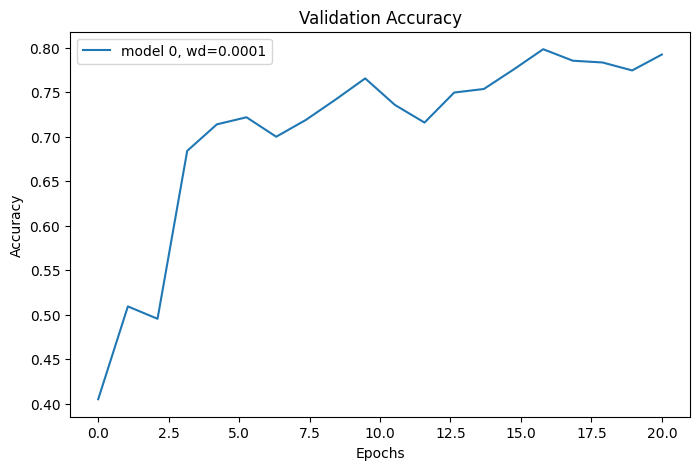

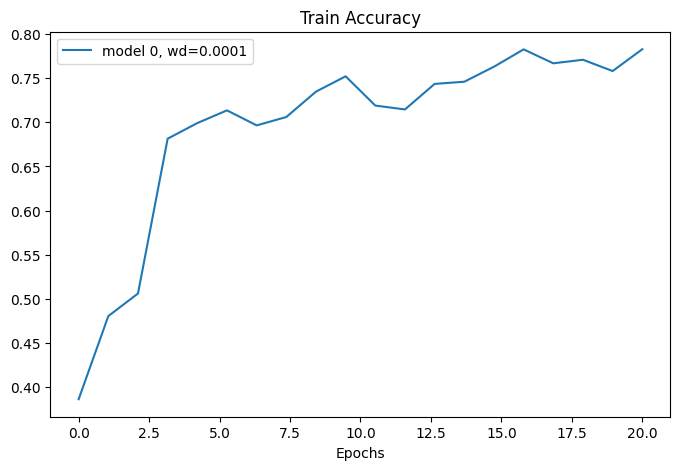

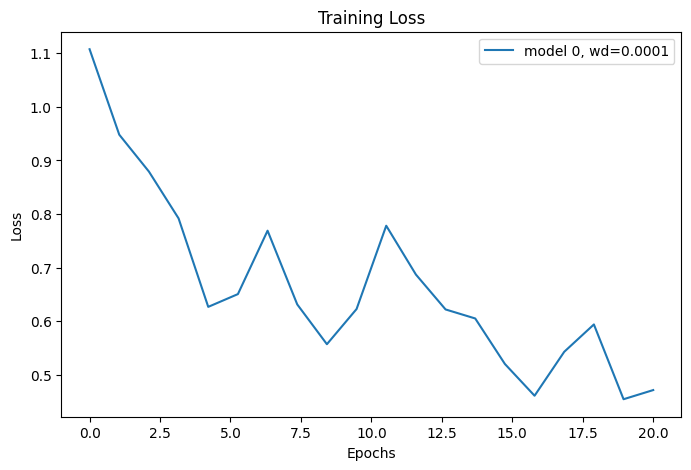

In [6]:
# Plot results from training
def plotAcc(models_label, models_acc):
    """ Plot validation accuracies to determine best model """

    plt.figure(figsize=(8, 5))
    plt.title("Validation Accuracy")
    for lab, accs in zip(models_label, models_acc):
        valacc = accs[:, 1]
        plt.plot(np.linspace(0, len(valacc), len(valacc)), valacc, label=lab)
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")

    plt.figure(figsize=(8, 5))
    plt.title("Train Accuracy")
    for lab, accs in zip(models_label, models_acc):
        valacc = accs[:, 0]
        plt.plot(np.linspace(0, len(valacc), len(valacc)), valacc, label=lab)
    plt.legend()
    plt.xlabel("Epochs")


def plotLosses(models_label, models_losses):
    """ Plot validation accuracies to determine best model """

    plt.figure(figsize=(8, 5))
    plt.title("Training Loss")
    for lab, loss in zip(models_label, models_losses):
        plt.plot(np.linspace(0, len(loss), len(loss)), loss, label=lab)
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    
    
def bestModelAcc(models_acc):
    """
    Prints test accuracy of best model
    Returns model that yields the best test accuracy
    """

    best_acc_idx = np.argmax([acc[-1, -1] for acc in models_acc])
    best_model = models[best_acc_idx]
    best_acc = S.acc_te(best_model)
    print(f"Accuracy of test set of best model (idx={best_acc_idx}): {best_acc*100:.1f}%")
    return best_acc 

# Plot
plotAcc(models_label, models_acc)
plotLosses(models_label, models_losses)
# Print accuracy
acc_best_FC = bestModelAcc(models_acc)

In [ ]:
# TODO: Clean this cell with new code 
# Convolutional architecture with 3 layers
# Investigate how number of channels and kernel size changes the results
class CNN2(nn.Module):    
    def __init__(self, channels, kernels, h_neurons, p_drop):
        super(CNN2, self).__init__()
     
        ch1, ch2, ch3 = channels
        k1, k2, k3 = kernels
        pad1, pad2, pad3 = int((k1-1)/2), int((k2-1)/2), int((k3-1)/2)
        h1, h2 = h_neurons
        p1, p2, p3 = p_drop

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(1, ch1, kernel_size=k1, padding=pad1),
            nn.Dropout(p1),
            nn.ReLU(),
            nn.Conv1d(ch1, ch2, kernel_size=k2, padding=pad2),
            nn.Dropout(p2),
            nn.ReLU(),
            nn.Conv1d(ch2, ch3, kernel_size=k3, padding=pad3),
            nn.Dropout(p3),
            nn.ReLU(),
            nn.MaxPool1d(4)   # Single pool layer with kernel=4 gave better results than 2 pool layers with kernel=2
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(ch3 * 7, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

# Fix kernels
kernels = [5, 5, 5]
# Test 3 different channels
channels = [16, 16, 16]      # Keep sizes of channels the same because there is not reduction in the image
# Test different sizes of hidden layers 
h_neurons = [300, 200]
# Test different rates of Dropout
p_drop = [[0, 0, 0]]

#Run training  
# Initialize results
models, models_losses, models_acc, models_label = [], [], [], []
for i, pp in enumerate(p_drop):

    model = CNN2(channels, kernels, h_neurons, pp)

    # Train
    losses, accuracies = trainModel(model, trainset, batch_size=64, max_epochs=30)

    models.append(model)
    models_losses.append(losses)
    models_acc.append(accuracies)
    models_label.append(f"model {i}, dropout={pp}")